In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy import stats
import pylab as plt
import torch
import swyft

## Simulator definition

In [3]:
class Simulator(swyft.Simulator):
    def __init__(self, bounds_n = None, bounds_z = None, Nbins = 100, sigma = .3):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.Nbins = Nbins
        self.sigma = sigma
        self.x = np.linspace(-1, 1, Nbins)
        
        self.z_sampler = swyft.RectBoundSampler(
            [stats.uniform(-.1, .2),
             stats.uniform(-.1, .2),
             stats.uniform(-.1, .2)
            ],
            bounds = bounds_z
        )
        
        self.n_sampler = swyft.RectBoundSampler(
            [stats.norm(0, np.ones(Nbins)*self.sigma),
            ],
            bounds = bounds_n
        )

    def calc_m(self, a, b, c):
        return 2*(a+b*self.x+c*self.x**2)
        
    def build(self, graph):
        n = graph.node("n", lambda: self.n_sampler())
        #n = graph.node("n", lambda: np.random.randn(self.Nbins)*self.sigma)
        z = graph.node("z", self.z_sampler)
        a, b, c = graph.node(['a', 'b', 'c'], lambda z: z, z)        
        m = graph.node("m", self.calc_m, a, b, c)
        d = graph.node("d", lambda m, n: m+n, m, n)
            

### Target observation and open bounds

In [4]:
NBINS = 1000
obs = Simulator(Nbins = NBINS).sample()
bounds_n = None
bounds_z = None

In [64]:
samples_n = torch.randn(10000, 1000)*0.3
samples_n = swyft.to_numpy32(samples_n)

## Define round simulator

In [72]:
sim = Simulator(Nbins = NBINS, bounds_n = bounds_n, bounds_z = bounds_z)

### Generate training data

In [73]:
def conditions():
    i = np.random.randint(10_000)
    n = samples_n[i]
    return {"n": n}
samples = sim.sample(10_000, conditions = conditions)
dm = swyft.SwyftDataModule(samples, fractions = [0.8, 0.1, 0.1], num_workers = 0, batch_size = 64)

  0%|          | 0/10000 [00:00<?, ?it/s]

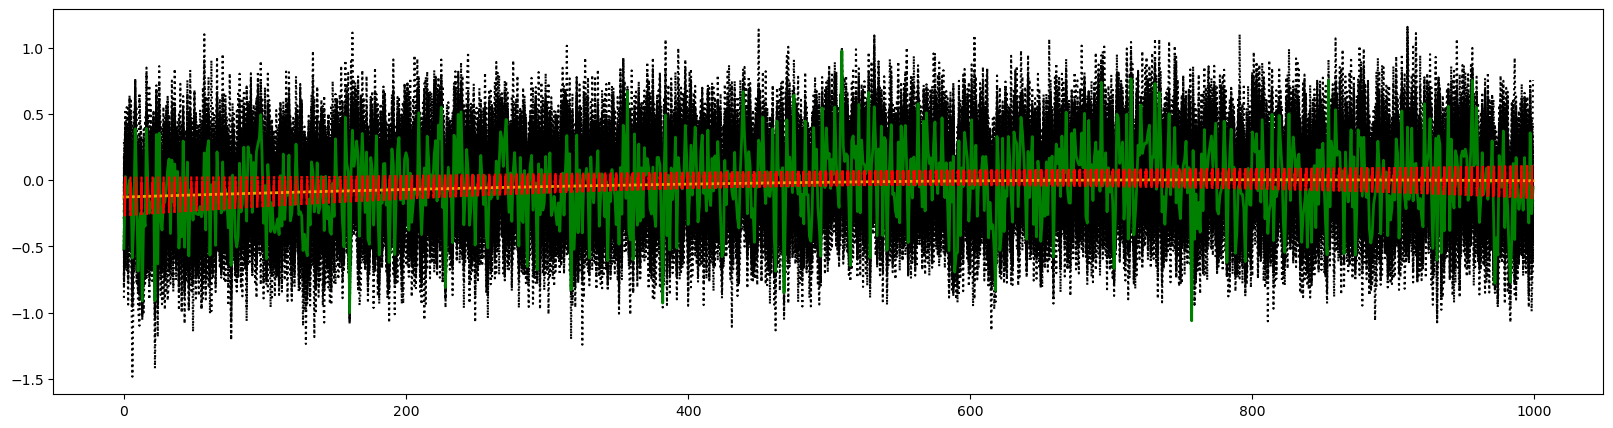

In [74]:
plt.figure(figsize = (20, 5))
for i in range(100):
    plt.plot(samples[i]['d'], 'k:')
    plt.plot(samples[i]['m'], 'r:', zorder = 100)
plt.plot(obs['d'], 'g', lw = 2)
plt.plot(obs['m'], 'y', lw = 2)

### Show sample std distribution as indicator for typical set coverage

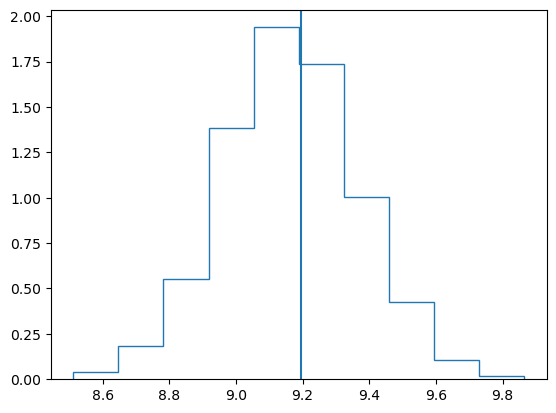

In [75]:
n0 = samples['n']
r0 = (n0**2).sum(axis=1)**0.5
plt.hist(r0, histtype='step', density=True);
rr = sum(obs['n']**2)**0.5
plt.axvline(rr)

## Define inference network

In [76]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.lin_1 = torch.nn.Linear(NBINS, 3)
        self.logratios1 = swyft.LogRatioEstimator_1dim(num_features = 3, num_params = 3, varnames = 'z')

        #self.conv1d_1 = torch.nn.Conv1d(1, 1, 5, padding = 2)
        #self.lin_2 = torch.nn.Linear(NBINS, 32)
        #self.logratios2 = swyft.LogRatioEstimator_1dim(num_features = 1, num_params = NBINS, varnames = 'n',
        #                                               hidden_features = 32, dropout = 0.0, num_blocks = 3)
        self.logratios3 = swyft.LogRatioEstimator_1dim_Gaussian(num_params = NBINS, varnames = 'n')
        self.optimizer_init = swyft.AdamOptimizerInit(lr = 1e-2, lrs_factor = 0.3, lrs_patience = 2)

    def forward(self, A, B):
        # Estimate parameters of parabola
        D = A['d']
        n = A['n']
        idx = torch.randperm(n.shape[0])
        n = n[idx].view(n.size())
        D = A['m'] + n
        f = self.lin_1(D)  # data summaries
        logratios1 = self.logratios1(f, B['z'])
        
        # Estimate
        #n = self.conv1d_1(A['d'].unsqueeze(-2)).squeeze(-2)  # data summaries
        #n = self.lin_2(A['d'])
        d = A['d'].unsqueeze(-1)#[...,:1]
        n = B['n']#[...,:1]
        #print(d.shape, n.shape)
        #print(d)
        #print(n)
        #qwerty
        #A_d, B_n = swyft.equalize_tensors(A['d'], B['n'])
        #logratios2 = self.logratios2(d, n)
        N = torch.randn_like(A['d'])*0.3
        logratios3 = self.logratios3(A['d']+N, B['n'])
 
        return logratios1, logratios3

network = Network()

In [77]:
trainer = swyft.SwyftTrainer(accelerator = 'cpu', devices=1, max_epochs = 10, precision = 32)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [78]:
trainer.fit(network, dm)


  | Name       | Type                            | Params
---------------------------------------------------------------
0 | lin_1      | Linear                          | 3.0 K 
1 | logratios1 | LogRatioEstimator_1dim          | 52.6 K
2 | logratios3 | LogRatioEstimator_1dim_Gaussian | 0     
---------------------------------------------------------------
55.6 K    Trainable params
0         Non-trainable params
55.6 K    Total params
0.222     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [79]:
prior_samples = sim.sample(30_000, targets = ['z', 'n'])

  0%|          | 0/30000 [00:00<?, ?it/s]

In [80]:
predictions = trainer.infer(network, obs, prior_samples)

Predicting: 125it [00:00, ?it/s]

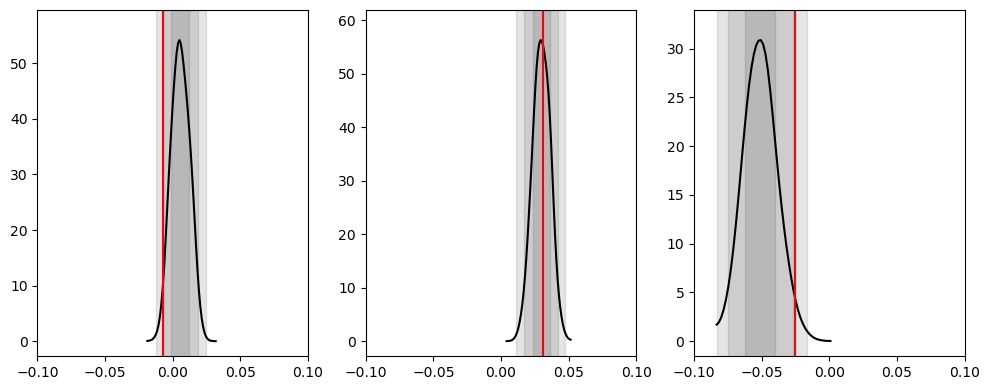

In [81]:
_, axs = plt.subplots(1, 3, figsize = (10, 4))
for i in range(3):
    swyft.plot_1d(predictions, "z[%i]"%i, ax = axs[i], bins=50, smooth = 2)
    axs[i].axvline(obs['z'][i], color='r')
    axs[i].set_xlim([-.1, 0.1])
plt.tight_layout()

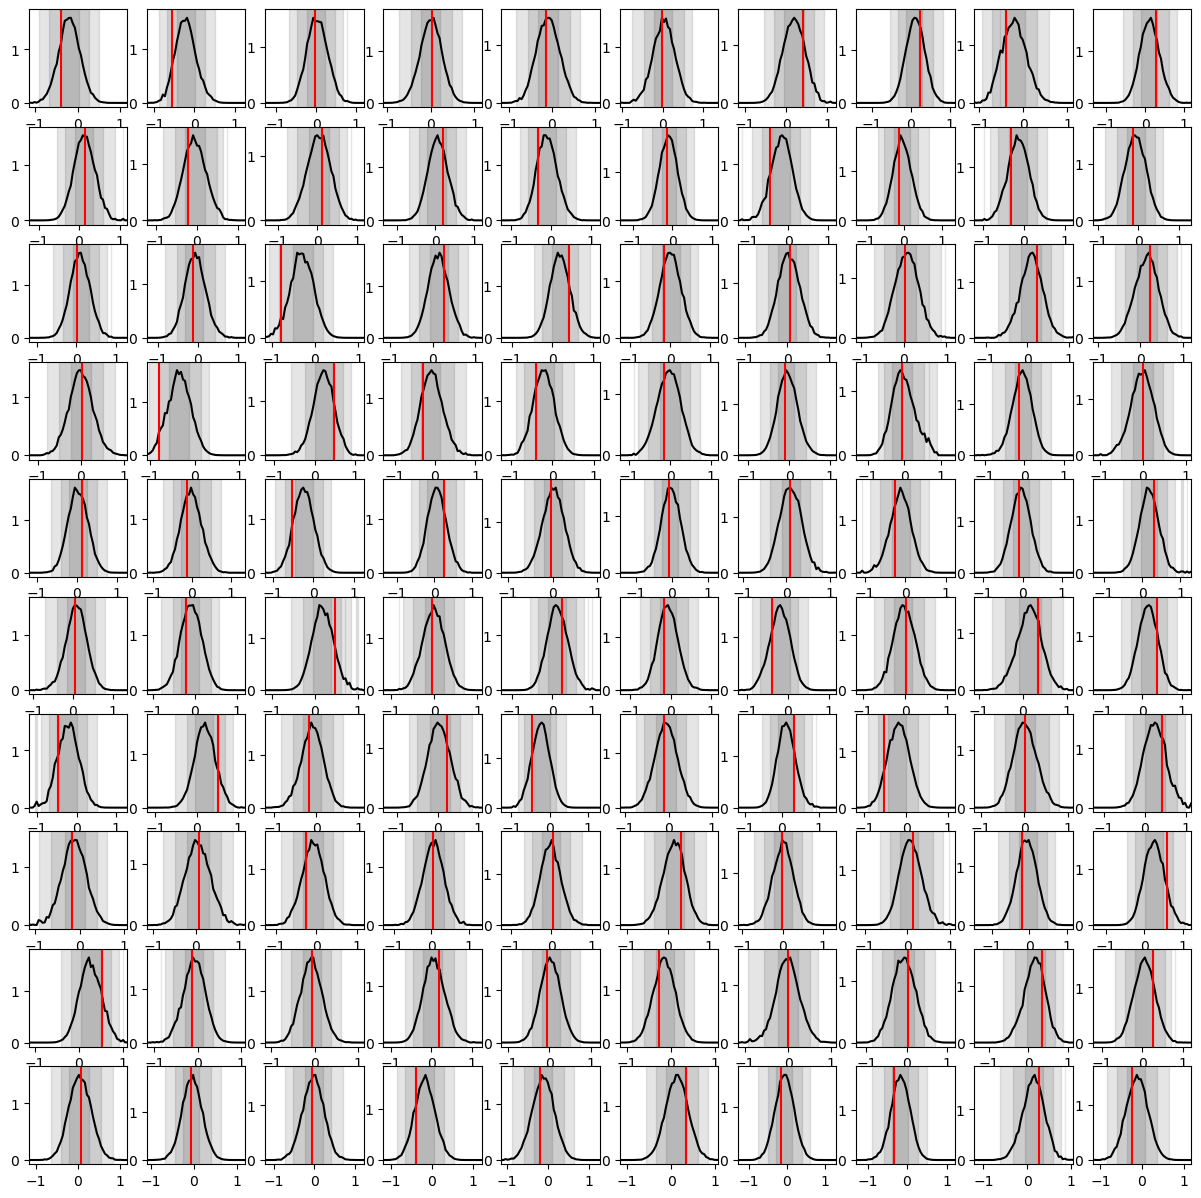

In [82]:
_, axs = plt.subplots(10, 10, figsize = (15, 15))
for i in range(10):
    for j in range(10):
        k = i + j*10
        swyft.plot_1d(predictions, "n[%i]"%k, ax = axs[i][j], bins=50)
        axs[i][j].axvline(obs['n'][k], color='r')

In [83]:
bounds_n = swyft.collect_rect_bounds(predictions[1], 'n', (NBINS,), threshold = 1e-6)
bounds_z = swyft.collect_rect_bounds(predictions[0], 'z', (3,), threshold = 1e-6)
bounds_n = None
bounds_z

tensor([[-0.0192,  0.0323],
        [ 0.0037,  0.0520],
        [-0.0842,  0.0017]])

In [84]:
weights = swyft.lightning.utils._get_weights(predictions[1].logratios*1, normalize = True)
params = predictions[1].params
idx = torch.multinomial(weights.T, 10000, replacement = True).T
idx = idx.unsqueeze(-1)
#idx.shape
samples_n = torch.gather(params, 0, idx).squeeze(-1)
samples_n.shape
samples_n = swyft.to_numpy32(samples_n)